# Mixed NB
* gnb : 'avg_rating' 피쳐 한개만
* mnb : alpha는 피쳐가 달라진 관계로(콤마, 띄어쓰기 제거) 다시 cv시행
    * ngram_range : (1, 2)
    * tfidf : true
    * sub_alpha : 0.3
    * score(mae) : 0.7674

In [1]:
df = pd.read_csv('../resource/final_df3.csv')
sample = df.title
y = df['rating(y)'].values
real_X = df[['avg_rating']].values
cat_X = df.text.fillna("").values

### training MultiNB & parameter tuning
* cat_X => countvec

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(cat_X)

tfidf_vect = TfidfVectorizer()
X_tfidf = tfidf_vect.fit_transform(cat_X)

In [3]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_absolute_error

### X_counts로 cv했을때
* alpha : 0.74
* score : 0.819739769701

best alpha :  1.1
best score :  0.766042332538
   1-sigma :  0.0537
sub_opt alpha :  0.74
sub_opt score :  0.819739769701


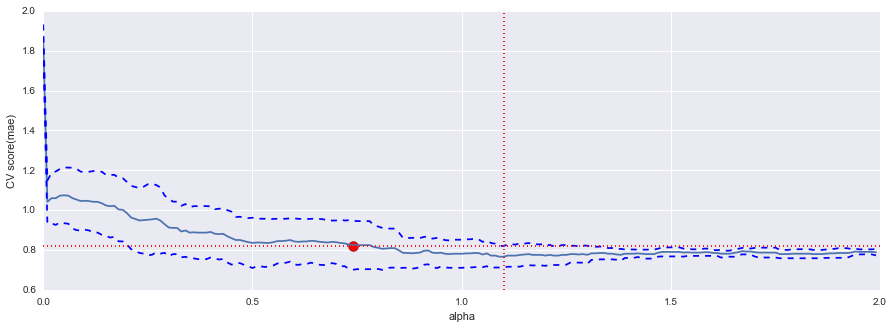

In [4]:
cv = StratifiedKFold(y, n_folds=5, random_state=51)

i_range = []
score_range = []
sigma = []

for a in np.arange(0, 2, 0.01):
    mnb = MultinomialNB(alpha = a)
    
    scores = np.zeros(5)
    
    for i, (train_idx, test_idx) in enumerate(cv):
        X_train = X_counts[train_idx]
        y_train = y[train_idx]
        X_test = X_counts[test_idx]
        y_test = y[test_idx]
        
        mnb.fit(X_train, y_train)
        y_pred = mnb.predict(X_test)
        
        scores[i] = mean_absolute_error(y_test, y_pred)

    i_range.append(a)
    score_range.append(np.mean(scores))
    sigma.append(np.std(scores))

best_idx = np.argmin(score_range)
best_alpha = i_range[best_idx]
best_score = score_range[best_idx]
sigma

plt.figure(figsize = (15, 5))
plt.plot(i_range, score_range)
plt.plot(i_range, np.array(score_range) + sigma, 'b--')
plt.plot(i_range, np.array(score_range) - sigma, 'b--')
plt.axhline(best_score + sigma[best_idx], linestyle=':', color='r')
plt.axvline(best_alpha, linestyle=':', color='r')

def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

sub_alpha = i_range[find_nearest(score_range, best_score+sigma[best_idx])]
sub_score = best_score+sigma[best_idx]

plt.scatter(sub_alpha, sub_score, s=100, c='red')
plt.xlim(0, 2)
plt.ylabel('CV score(mae)')
plt.xlabel('alpha')

print("best alpha : ", best_alpha)
print("best score : ", best_score)
print('   1-sigma : ', round(sigma[best_idx], 4))
print('='*25)
print("sub_opt alpha : ", sub_alpha)
print("sub_opt score : ", sub_score)  

### X_tfidf로 cv했을때
* alpha : 0.23
* score : 0.791257638511

best alpha :  0.42
best score :  0.755124397064
   1-sigma :  0.0361
sub_opt alpha :  0.23
sub_opt score :  0.791257638511


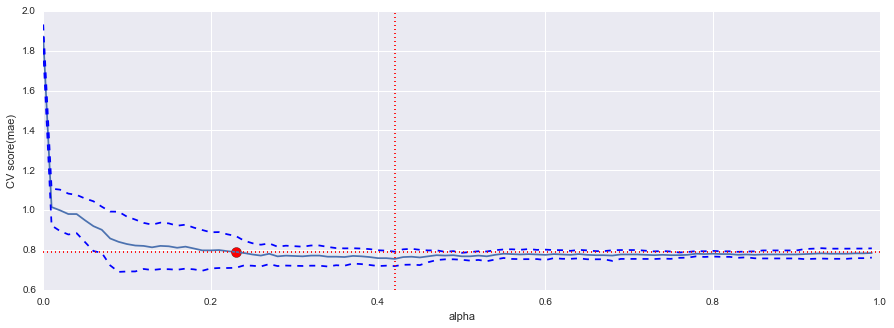

In [5]:
cv = StratifiedKFold(y, n_folds=5, random_state=51)

i_range = []
score_range = []
sigma = []

for a in np.arange(0, 1, 0.01):
    mnb = MultinomialNB(alpha = a)
    
    scores = np.zeros(5)
    
    for i, (train_idx, test_idx) in enumerate(cv):
        X_train = X_tfidf[train_idx]
        y_train = y[train_idx]
        X_test = X_tfidf[test_idx]
        y_test = y[test_idx]
        
        mnb.fit(X_train, y_train)
        y_pred = mnb.predict(X_test)
        
        scores[i] = mean_absolute_error(y_test, y_pred)

    i_range.append(a)
    score_range.append(np.mean(scores))
    sigma.append(np.std(scores))

best_idx = np.argmin(score_range)
best_alpha = i_range[best_idx]
best_score = score_range[best_idx]
sigma

plt.figure(figsize = (15, 5))
plt.plot(i_range, score_range)
plt.plot(i_range, np.array(score_range) + sigma, 'b--')
plt.plot(i_range, np.array(score_range) - sigma, 'b--')
plt.axhline(best_score + sigma[best_idx], linestyle=':', color='r')
plt.axvline(best_alpha, linestyle=':', color='r')

def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

sub_alpha = i_range[find_nearest(score_range, best_score+sigma[best_idx])]
sub_score = best_score+sigma[best_idx]

plt.scatter(sub_alpha, sub_score, s=100, c='red')
plt.xlim(0, 1)
plt.ylabel('CV score(mae)')
plt.xlabel('alpha')

print("best alpha : ", best_alpha)
print("best score : ", best_score)
print('   1-sigma : ', round(sigma[best_idx], 4))
print('='*25)
print("sub_opt alpha : ", sub_alpha)
print("sub_opt score : ", sub_score)

### Tuning & Improvement

In [6]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB()),
    ])

In [7]:
from sklearn.grid_search import GridSearchCV
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), ],
    'tfidf__use_idf' : [True, False],
    'clf__alpha' : np.arange(0, 1, 0.01),
}
gs_clf = GridSearchCV(text_clf, parameters, cv=5, scoring='mean_absolute_error', n_jobs=-1)
gs_clf = gs_clf.fit(cat_X, y)

In [8]:
best_parameters, score, _ = max(gs_clf.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters.keys()):
    print("{name}: {best}".format(
        name=param_name, best=best_parameters[param_name]
        ))
print("="*25)
print('score :', score)

clf__alpha: 0.42
tfidf__use_idf: True
vect__ngram_range: (1, 2)
score : -0.75


### Retraining with new parameters & 1sigma rule

best alpha :  0.42
best score :  0.749690507658
   1-sigma :  0.0177
sub_opt alpha :  0.3
sub_opt score :  0.76739549574


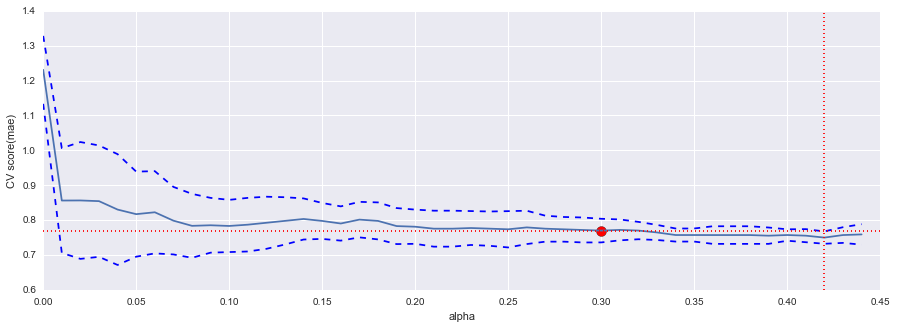

In [9]:
cv = StratifiedKFold(y, n_folds=5, random_state=51)

i_range = []
score_range = []
sigma = []

for a in np.arange(0, 0.45, 0.01):
    text_clf = Pipeline([
            ('vect', CountVectorizer(ngram_range=(1, 2))), 
            ('tfidf', TfidfTransformer()), 
            ('clf', MultinomialNB(alpha=a)),
        ])
    
    scores = np.zeros(5)
    
    for i, (train_idx, test_idx) in enumerate(cv):
        X_train = cat_X[train_idx]
        y_train = y[train_idx]
        X_test = cat_X[test_idx]
        y_test = y[test_idx]
        
        text_clf.fit(X_train, y_train)
        y_pred = text_clf.predict(X_test)
        
        scores[i] = mean_absolute_error(y_test, y_pred)

    i_range.append(a)
    score_range.append(np.mean(scores))
    sigma.append(np.std(scores))

best_idx = np.argmin(score_range)
best_alpha = i_range[best_idx]
best_score = score_range[best_idx]
sigma

plt.figure(figsize = (15, 5))
plt.plot(i_range, score_range)
plt.plot(i_range, np.array(score_range) + sigma, 'b--')
plt.plot(i_range, np.array(score_range) - sigma, 'b--')
plt.axhline(best_score + sigma[best_idx], linestyle=':', color='r')
plt.axvline(best_alpha, linestyle=':', color='r')

def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

sub_alpha = i_range[find_nearest(score_range, best_score+sigma[best_idx])]
sub_score = best_score+sigma[best_idx]

plt.scatter(sub_alpha, sub_score, s=100, c='red')
plt.xlim(0, 0.45)
plt.ylabel('CV score(mae)')
plt.xlabel('alpha')

print("best alpha : ", best_alpha)
print("best score : ", best_score)
print('   1-sigma : ', round(sigma[best_idx], 4))
print('='*25)
print("sub_opt alpha : ", sub_alpha)
print("sub_opt score : ", sub_score)

### Gaussian & Multinomial NB fitting
* gnb : 'avg_rating' 피쳐 한개만
* mnb : alpha는 피쳐가 달라진 관계로(콤마, 띄어쓰기 제거) 다시 cv시행
    * ngram_range : (1, 2)
    * tfidf : true
    * sub_alpha : 0.3
    * score(mae) : 0.7674

In [10]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
gnb = GaussianNB()
mnb = Pipeline([
        ('vect', CountVectorizer(ngram_range=(1, 2),)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB(alpha=0.3)),
    ])

gnb.fit(real_X, y)
gnb_pred = gnb.predict(real_X)
gnb_prob = gnb.predict_proba(real_X)

mnb.fit(cat_X, y)
mnb_pred = mnb.predict(cat_X)
mnb_prob = mnb.predict_proba(cat_X)

mix_prob = np.multiply(gnb_prob, mnb_prob)
mix_prob.shape

(544L, 5L)

In [11]:
def softmax(w, t=1.0):
    """Calculate the softmax of a list of numbers w.

    Parameters
    ----------
    w : list of numbers
    t : float

    Return
    ------
    a list of the same length as w of non-negative numbers

    Examples
    --------
    >>> softmax([0.1, 0.2])
    array([ 0.47502081,  0.52497919])
    >>> softmax([-0.1, 0.2])
    array([ 0.42555748,  0.57444252])
    >>> softmax([0.9, -10])
    array([  9.99981542e-01,   1.84578933e-05])
    >>> softmax([0, 10])
    array([  4.53978687e-05,   9.99954602e-01])
    """
    e = np.exp(np.array(w) / t)
    dist = e / np.sum(e)
    return dist

In [12]:
mix_prob_softmax = np.zeros((544, 5))
for i in range(544):
    mix_prob_softmax[i] = softmax(mix_prob[i])
mix_prob_softmax
np.sum(mix_prob_softmax[0])

0.99999999999999978

In [13]:
mix_pred = np.zeros(544, )
for i in range(544):
    mix_pred[i] = np.argmax(mix_prob_softmax[i])
mix_pred += 1 # 별점은 1점부터 5점까지이므로(int)
mix_pred

array([ 3.,  2.,  4.,  2.,  3.,  2.,  3.,  3.,  2.,  4.,  4.,  3.,  3.,
        3.,  3.,  3.,  4.,  4.,  3.,  3.,  3.,  4.,  3.,  3.,  1.,  3.,
        3.,  3.,  4.,  3.,  3.,  4.,  4.,  4.,  4.,  4.,  4.,  3.,  3.,
        4.,  4.,  4.,  3.,  4.,  4.,  4.,  3.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  2.,  4.,  3.,  2.,  4.,  3.,  4.,  1.,  1.,
        2.,  2.,  4.,  1.,  2.,  3.,  5.,  3.,  3.,  2.,  4.,  3.,  2.,
        3.,  5.,  4.,  3.,  3.,  2.,  3.,  3.,  3.,  3.,  2.,  3.,  1.,
        1.,  3.,  2.,  1.,  2.,  1.,  3.,  2.,  3.,  4.,  3.,  4.,  3.,
        4.,  3.,  4.,  3.,  4.,  2.,  4.,  3.,  4.,  3.,  1.,  2.,  2.,
        3.,  3.,  3.,  3.,  3.,  3.,  4.,  3.,  4.,  3.,  3.,  4.,  3.,
        4.,  3.,  4.,  4.,  4.,  4.,  4.,  3.,  3.,  4.,  3.,  3.,  2.,
        4.,  2.,  4.,  4.,  3.,  3.,  3.,  3.,  4.,  3.,  3.,  3.,  3.,
        3.,  3.,  4.,  3.,  3.,  3.,  4.,  3.,  2.,  2.,  3.,  5.,  3.,
        3.,  3.,  3.,  4.,  3.,  1.,  3.,  3.,  3.,  2.,  3.,  3

### Final Test

In [14]:
test_df = pd.read_excel('../resource/test_df.xlsx')
test_sample = test_df.title
test_y = test_df['my_rating'].values
test_real_X = test_df[['avg_rating']].values
test_cat_X = test_df.text
test_watcha_y = test_df['watcha_rating'].values

In [15]:
gnb_test_pred = gnb.predict(test_real_X)
gnb_test_prob = gnb.predict_proba(test_real_X)
mnb_test_pred = mnb.predict(test_cat_X)
mnb_test_prob = mnb.predict_proba(test_cat_X)

mix_test_prob = np.multiply(gnb_test_prob, mnb_test_prob)
mix_test_prob_softmax = np.zeros((12, 5))
for i in range(12):
    mix_test_prob_softmax[i] = softmax(mix_test_prob[i])
mix_test_prob_softmax
np.sum(mix_test_prob_softmax[0])

mix_test_pred = np.zeros(12, )
for i in range(12):
    mix_test_pred[i] = np.argmax(mix_test_prob_softmax[i])
mix_test_pred += 1 # 별점은 1점부터 5점까지이므로(int)
mix_test_pred

array([ 4.,  1.,  3.,  1.,  3.,  4.,  3.,  4.,  4.,  4.,  4.,  4.])

In [16]:
test_df['predict'] = mix_test_pred
test_df

,title,avg_rating,text,watcha_rating,my_rating,predict
0,아노말리사,3.72008,찰리카프먼 제니퍼제이슨리 데이빗듈리스 톰누난 청소년관람불가 애니메이션 미국,3.423718,4,4
1,방안의 코끼리,2.50431,권칠인 곽시양 신동미 김태한 청소년관람불가 미상 한국,2.700460,2,1
2,거짓말은자란다,3.05238,이시카와준이치 토다에리카 마츠자카토리 오자와유키요시 15세관람가 코미디 일본,3.005566,4,3
3,보이 7,2.52941,로렌스블록 매티스반드샌드바쿠이젠 엘라준헨라드 티호헤르난트 SF 네덜란드,1.942025,1,1
4,엑스 마키나,3.46250,알렉스가랜드 노덜클리슨 알리시아비칸데르 오스카아이삭 청소년관람불가 드라마 미국 영국,3.397823,3,3
5,세븐,4.05060,데이빗핀처 브래드피트 모건프리먼 기네스팰트로우 청소년관람불가 스릴러 미국,4.063673,4,4
6,어벤져스 : 에이지 오브 울트론,3.78890,조스웨던 로버트다우니주니어 크리스헴스워스 마크러팔로 12세관람가 액션 미국,3.555236,3,3
7,인사이드아웃,4.15653,피트닥터 민디캘링 에이미포엘러 빌헤이더 전체관람가 애니메이션 미국,4.095977,5,4
8,빅쇼트,3.89942,아담맥케이 크리스찬베일 스티브카렐 라이언고슬링 청소년관람불가 드라마 미국,3.835082,4,4
9,주토피아,4.31814,바이론하워드 지니퍼굿윈 제이슨베이트먼 알란터딕 전체관람가 애니메이션 미국,3.769957,4,4


### score

In [17]:
mix_score = mean_absolute_error(mix_test_pred, test_y)
watcha_score = mean_absolute_error(test_watcha_y, test_y)

print('mix_score :', mix_score)
print('watcha_score :', watcha_score)

mix_score : 0.25
watcha_score : 0.478241188176


In [18]:
# watcha_rating을 반올림하여 정수로변환하여 스코어 측정해봄
test_watchar_round_y = np.round(test_watcha_y,)
mean_absolute_error(test_watchar_round_y, test_y)

0.5